In [1]:
"""
Autor: Jairo Valea López

Programa de apoyo al análisis de fotografías en el entorno del prototipo
de disipación de niebla en la autovía A-8 (Fiouco) del GSJ.

Se valora también la detección automática del contorno del cartel.
"""

# Cargado de librerías necesarias

import os
import csv
import time
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime # formato fecha
#import seaborn as sbs
from PIL import Image, ImageFile
from natsort import natsorted, ns # ordenación de las imágenes
from random import seed, random, randint # aleatoriedad
from skimage import color, io, filters, exposure # manejo de imágenes
from skimage.segmentation import active_contour # contorno de carteles
from tqdm.notebook import tqdm, trange, tnrange # barra de progreso

ImageFile.LOAD_TRUNCATED_IMAGES = True
R, G, B = 0, 1, 2
L = 256

def promedio(lst):
    return sum(lst) / len(lst)

def sig_rand():
    y = random()
    if (y < 0.5):
        s = -1
    else: s = 1
    return s

def mejora(neg_fue,bla_fue,neg_den,bla_den):
    fuera = promedio(bla_fue) - promedio(neg_fue)
    dentro = promedio(bla_den) - promedio(neg_den)
    mej = dentro - fuera
    return mej

def arco_cartel(snake):
    long = []
    for i in range(len(snake)-2):
        long.append(((snake[i+1,0]-snake[i,0])**2+(snake[i+1,1]-snake[i,1])**2)**0.5)
    return sum(long)

def visibilidad(blanco,negro):
    v_claro = 181.67 # obtenida a partir de la última imagen del Ensayo 15 (tomada 11 Ago 2021 - 12:39:26)
    d = 76  # distancia estimada de la foto al cartel
    promedios = np.clip(promedio(blanco) - promedio(negro), a_min = 0.001, a_max = 255)
    viz = np.clip(round(3/((-1/d)*np.log((promedios)/v_claro)),2), a_min = 10, a_max = 2000)
    return viz

In [2]:
ensayo = 'b_33'
img_folder = 'C:/Users/miguel.anton/Desktop/NIEBLA/Fotos_estudio/' + ensayo     # CAMBIAR CARPETA

yfuera = 1721
xfuera = 1378
ydentro = 2320
xdentro = 1394

# coordenadas del centro de los carteles, dependientes de la foto                   ___> (y)
# por cosas de Numpy, al parecer las coordenadas están invertidas                  |
# (0,0) está en la esquina superior izq, X crece hacia abajo e Y hacia la derecha  v (x)
# Por el movimiento de la cámara, CAMBIAN PARA CADA ENSAYO

'''
ENSAYO BURÉS 8 10-08-2021 (b_08)
yfuera = 1510
xfuera = 1387
ydentro = 2112
xdentro = 1408

ENSAYO BURÉS 9 10-08-2021 (b_09)
yfuera = 1469
xfuera = 1056
ydentro = 2082
xdentro = 1078

ENSAYO BURÉS 10 11-08-2021 (b_10) aprox
yfuera = 1609
xfuera = 1433
ydentro = 2218
xdentro = 1445

ENSAYO BURÉS 11 11-08-2021 (b_11)
yfuera = 1470
xfuera = 1357
ydentro = 2076
xdentro = 1375

ENSAYO BURÉS 12 11-08-2021 (b_12)
yfuera = 1477
xfuera = 1378
ydentro = 2082
xdentro = 1392

ENSAYO BURÉS 13 11-08-2021 (b_13)
yfuera = 1424
xfuera = 1373
ydentro = 2031
xdentro = 1388

ENSAYO BURÉS 14 11-08-2021 (b_14)
yfuera = 1421
xfuera = 1371
ydentro = 2030
xdentro = 1387

ENSAYO BURÉS 15 11-08-2021 (b_15)
yfuera = 1411
xfuera = 1362
ydentro = 2020
xdentro = 1374

ENSAYO BURÉS 16 19-08-2021 (b_16)
yfuera = 1821
xfuera = 1008
ydentro = 2426
xdentro = 1046

ENSAYO BURÉS 17 19-08-2021 (b_17)
yfuera = 1823
xfuera = 1193
ydentro = 2422
xdentro = 1230

ENSAYO BURÉS 18 19-08-2021 (b_18)
yfuera = 1845
xfuera = 1284
ydentro = 2442
xdentro = 1317

ENSAYO BURÉS 19 19-08-2021 (b_19)
yfuera = 1726
xfuera = 1218
ydentro = 2325
xdentro = 1254

ENSAYO 19 SOLO NIEBLA 19-08-2021 (b_19_soloniebla)
yfuera = 1781
xfuera = 1209
ydentro = 2382
xdentro = 1245

ENSAYO BURÉS (PURO) 20 19-08-2021 (b_20)
yfuera = 1710
xfuera = 1319
ydentro = 2308
xdentro = 1351

ENSAYO BURÉS 21 23-08-2021 (b_21)
NO SE VE

ENSAYO BURÉS 22 23-08-2021 (b_21)
yfuera = 1616
xfuera = 1312
ydentro = 2216
xdentro = 1338

ENSAYO CEPSA 01 23-08-2021 (c01)
NO SE VE

ENSAYO BASF-PLURIOL 01 23-08-2021 (ol01)
yfuera = 1687
xfuera = 1310
ydentro = 2286
xdentro = 1347

ENSAYO SIN SURFACTANTE 3 19-08-2021 (ss03)
yfuera = 1780
xfuera = 1218
ydentro = 2378
xdentro = 1248

...

ENSAYO BURÉS 33 27-08-2021 (b_33)
yfuera = 1721
xfuera = 1378
ydentro = 2320
xdentro = 1394
'''

print('Coordenadas iniciales introducidas - Ensayo', ensayo)

Coordenadas iniciales introducidas - Ensayo b_33


In [3]:
images = []
nombres = []

t = time.time()
carpeta = natsorted(os.listdir(img_folder)) 
for f in carpeta:
    name, ext = os.path.splitext(f)
    if ext == '.jpg':
        images.append(io.imread(img_folder + '\\' + name + ext, as_gray = True))
        nombres.append(name + ext)
    
for i in range(len(images)):
    images[i] = images[i][(xfuera-100):(xdentro+100),(yfuera-100):(ydentro+100)]
    # cortado de la imagen, dependiente de las coordenadas iniciales dadas, a analizar en cada pasada
    # 10-08-2021: ahora el trípode está señalado, no debería cambiar en demasía
    
yfuera = 100    # transformación en coordenadas de la imagen recortada
xfuera = 100    # 
ydentro = len(images[i][1]) - 100
xdentro = len(images[i]) - 100
    
print(str(len(images)),'imágenes cargadas en',str(round(time.time()-t,2)),'segundos')

31 imágenes cargadas en 29.34 segundos


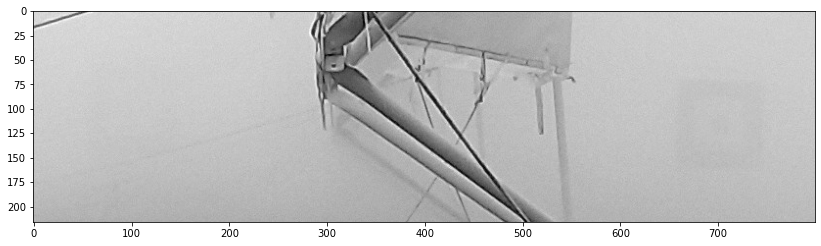

  0%|          | 0/31 [00:00<?, ?it/s]

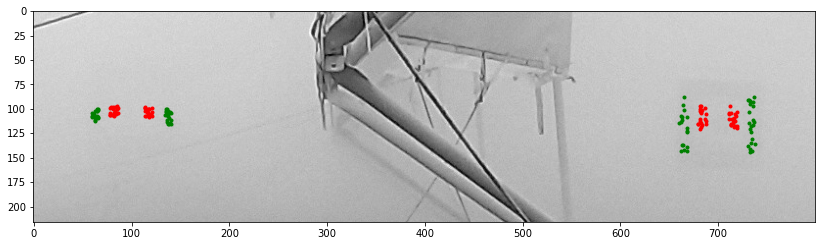

In [4]:
ejemplo = randint(0,len(nombres))

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(images[ejemplo],cmap=plt.cm.gray)
plt.show()

# implementación para n imágenes

c_neg_fuera = [[] for i in range(len(images))]   # lista de coord de los puntos tomados de la zona negra del cartel de fuera
c_bla_fuera = [[] for i in range(len(images))]   # etc
c_neg_dentro = [[] for i in range(len(images))]  # 
c_bla_dentro = [[] for i in range(len(images))]

neg_fuera = [[] for i in range(len(images))]     # valores de la luminosidad de los puntos tomados de c_neg_fuera
bla_fuera = [[] for i in range(len(images))]     # etc
neg_dentro = [[] for i in range(len(images))]    #
bla_dentro = [[] for i in range(len(images))]    #

numpuntos = 40  # número de puntos a tomar en cada cartel, igual para el área blanca que para el área negra

for j in tnrange(len(images)):
    for i in range(numpuntos):
        c_neg_fuera[j].append([xfuera+randint(0,15),yfuera+sig_rand()*randint(34,40)])
        c_bla_fuera[j].append([xfuera+randint(-3,8),yfuera+sig_rand()*randint(14,22)])
        c_neg_dentro[j].append([xdentro+sig_rand()*randint(0,28),ydentro+sig_rand()*randint(31,39)])
        c_bla_dentro[j].append([xdentro+randint(-20,5),ydentro+sig_rand()*randint(12,20)])
        neg_fuera[j].append(255*images[j][c_neg_fuera[j][i][0],c_neg_fuera[j][i][1]])
        bla_fuera[j].append(255*images[j][c_bla_fuera[j][i][0],c_bla_fuera[j][i][1]])
        neg_dentro[j].append(255*images[j][c_neg_dentro[j][i][0],c_neg_dentro[j][i][1]])
        bla_dentro[j].append(255*images[j][c_bla_dentro[j][i][0],c_bla_dentro[j][i][1]])
        
# IMAGEN DE EJEMPLO (UNA SOLA)

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(images[ejemplo],cmap=plt.cm.gray)

for i in range(numpuntos):
    ax.plot(c_neg_fuera[ejemplo][i][1],c_neg_fuera[ejemplo][i][0], '.g')
    ax.plot(c_bla_fuera[ejemplo][i][1],c_bla_fuera[ejemplo][i][0], '.r')
    ax.plot(c_neg_dentro[ejemplo][i][1],c_neg_dentro[ejemplo][i][0], '.g')
    ax.plot(c_bla_dentro[ejemplo][i][1],c_bla_dentro[ejemplo][i][0], '.r')
plt.show()

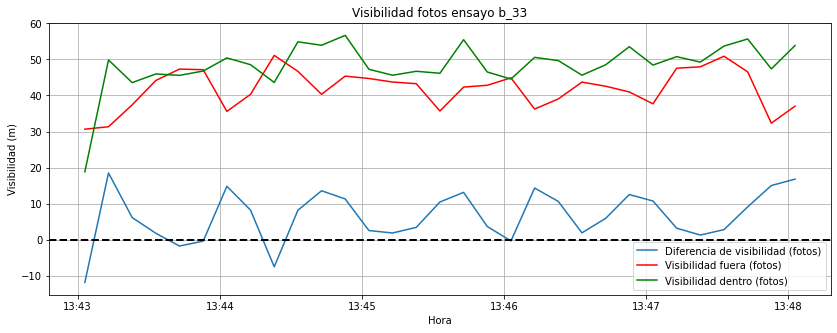

In [10]:
tiempo = []
visib_dentro = []
visib_fuera = []
ganancia_vis = []
vc = []

import matplotlib.dates as mdates

for j in range(len(images)):
    tiempo.append(nombres[j][-19:-4])   # -19:-4 cuando Teresa no renombra las fotos
                                         # -23:-8 en el ensayo 11, 16, 17, 18
                                         # -26:-11 en el ensayo 10, 15
    visib_dentro.append(visibilidad(bla_dentro[j],neg_dentro[j]))
    visib_fuera.append(visibilidad(bla_fuera[j],neg_fuera[j]))
    tiempo[j] = datetime.datetime.strptime(tiempo[j], '%Y%m%d_%H%M%S')

    
#visi = pd.read_csv(img_folder + '/visi.csv', sep=";")
#for k in range(len(visi['T'])):
#    vc.append(datetime.datetime.strptime(visi['T'][k], '%d.%m.%Y %H:%M:%S'))

ganancia_vis = np.subtract(visib_dentro,visib_fuera)

fig, ax = plt.subplots(figsize = (14,5))
plt.plot(tiempo, ganancia_vis, label = 'Diferencia de visibilidad (fotos)')
plt.plot(tiempo, visib_fuera, color = 'red', label = "Visibilidad fuera (fotos)")
plt.plot(tiempo, visib_dentro, color = 'green', label = "Visibilidad dentro (fotos)")
#plt.scatter(vc, visi['Inst'], color = 'black', marker = '.', label = "Datos visibilímetro")
#for j in range(len(visi['T'])):
#    ax.annotate(visi['Inst'][j], xy = (vc[j], visi['Inst'][j]), fontsize = 'small')
plt.axhline(y=0, color='black', linewidth = 2, linestyle='--')
#plt.axvline(x=tiempo[9], color='purple', linestyle='dotted', linewidth = 1.5, label = "Fin difusiones")
#plt.axvline(x=tiempo[16], color='purple', linestyle='dotted', linewidth = 1.5)
#plt.axvline(x=tiempo[2], color='purple', linestyle='dotted', linewidth = 1.5)
ax.legend(loc = "lower right")
ax.set_title('Visibilidad fotos ensayo ' + ensayo)
ax.set_xlabel('Hora')
ax.set_ylabel('Visibilidad (m)')
#ax.set_ylim(-40,80)
ax.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) # formato correcto de hora:minuto en los ejes
plt.savefig(img_folder+ '/' + 'VISIB.png')
plt.show()


In [66]:
header = ['Foto', 'Hora','Vis_dentro','Vis_fuera','Mejora']
a_exportar = np.array([nombres,tiempo,visib_dentro,visib_fuera,ganancia_vis],dtype=object).T

with open(img_folder + '/' + 'datos_visibilidad.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f, delimiter=';')
    writer.writerow(header)
    writer.writerows(a_exportar)

In [43]:
# contorno - ignorado por ahora

'''
s = np.linspace(0, 2*np.pi, 400)
yf = xfuera + 75*np.sin(s)
xf = yfuera + 75*np.cos(s)
yd = xdentro + 75*np.sin(s)
xd = ydentro + 75*np.cos(s)
inicial_fuera = np.array([yf, xf]).T
inicial_dentro = np.array([yd, xd]).T

for j in trange(len(images)):
    snaked = active_contour(filters.gaussian(images[j], 3, preserve_range=False), inicial_dentro, alpha=0.015, beta=1, gamma=0.0010,w_edge=1.2,coordinates='rc')
    snakef = active_contour(filters.gaussian(images[j], 3, preserve_range=False), inicial_fuera, alpha=0.015, beta=1, gamma=0.0010,coordinates='rc')

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(images[11], cmap=plt.cm.gray)
ax.plot(inicial_dentro[:, 1], inicial_dentro[:, 0], '-.g', lw=1)
ax.plot(inicial_fuera[:, 1], inicial_fuera[:, 0], '-.g', lw=1)
ax.plot(snaked[:, 1], snaked[:, 0], '-r', lw=2)
ax.plot(snakef[:, 1], snakef[:, 0], '-b', lw=2)
ax.set_title('Imagen '+carpeta[11])
'''
print('')